# Hierarchical Bayesian Modeling with FRANKEN-Z

Now that we've demonstrated FRANKEN-Z works in the naive case and that we deal with missing data, we will begin moving on to hierarchical modeling. 

Why would we want to do this? Two main motivations:
- Hierarchical models allow the derivation of joint densities between the individual and population, which allows us to properly model **covariances**. This is crucial for understanding how the population can impact individual PDFs, and how the individual PDFs can impact the entire population (via their respective densities in flux space).
- In addition, hierarchical models allow us to start including **selection effects** into our model. While the easiest case to understand involve simple flux boundaries, we'll leverage machine learning to try and incorporate more difficult selection functions.

Let's initialize the environment

In [1]:
import sys # system commands
from scipy import stats # statistics

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing mock data...

In [2]:
# load observed data
data=load('mock_catalog_hsc-cosmos.npy')
phot_d=data[:,[0,1,2,3,4]] # fluxes
err_d=data[:,[5,6,7,8,9]] # flux errors
var_d=square(err_d) # flux variances
mask_d=(err_d>0.) # mask for missing data
redshift_d=data[:,10] # redshifts
types_d=data[:,11].astype(int) # types
Nobs=len(data) # number of objects

Nclass=(8,11,12) # passive, spiral, and starburst galaxies, respectively
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y 5-sigma limits for HSC data

Nf=len(phot_d[0]) # number of filters
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(sqrt(var_d),axis=0)
mag_d,magerr_d=fz.asinh_mag_map(phot_d,err_d,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# load model data
models=load('model_catalog_hsc-cosmos.npy')
phot_m=models[:,[0,1,2,3,4]] # fluxes
err_m=zeros(phot_m.shape) # flux errors
var_m=square(err_m) # flux variances
mask_m=ones(phot_m.shape).astype(bool) # mask for missing data
redshift_m=models[:,-2] # redshifts
types_m=models[:,-1].astype(int) # types
Nmodels=len(models) # number of objects

# template grid
Ut,t_inv=unique(types_m,return_inverse=True) # order unique types
Nt=len(Ut) # number of unique types

# redshift grid
Uz,z_inv=unique(redshift_m,return_inverse=True) # ordered unique redshifts
Nz=len(Uz) # number of unique redshifts
dz=Uz[1]-Uz[0]

# discretize redshifts
zidx_m=((redshift_m-Uz[0])/(Uz[1]-Uz[0])).round().astype(int)

Applying selection function...

In [3]:
sel=(mag_d[:,2]<maglims[2]) # applying i-band cut
Nsel = sel.sum() # number of galaxies post-cut
print 'Number of observed galaxies (all):',Nobs
print 'Number of observed galaxies (selected):',Nsel
print 'Number of models:',Nmodels

Number of observed galaxies (all): 500000
Number of observed galaxies (selected): 181162
Number of models: 18631


Importing FRANKEN-Z config files...

In [4]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# discretize data
lzidx_d,lzeidx_d=rdict.fit(log(1+redshift_d),ones(Nobs)*rdict.dlz)
lzidx_m,lzeidx_m=rdict.fit(log(1+redshift_m),ones(Nmodels)*rdict.dlz)

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color
midx_d,meidx_d=mdict.fit(mag_d,magerr_d)

Computing train/test split...

In [5]:
# select training/testing samples
ftrain=0.4 # fraction of sample available for training
Ntrain=int(Nsel*ftrain) # number of training objects
Ntest=Nsel-Ntrain
train_sel=zeros(Nsel).astype(bool)
train_sel[choice(Nsel,size=Ntrain,replace=False)]=True # training selection flag
test_sel=(train_sel==False) # testing selection flag

# define training/testing data
phot_train_d,var_train_d,mask_train_d=phot_d[sel][train_sel],var_d[sel][train_sel],mask_d[sel][train_sel] 
phot_test_d,var_test_d,mask_test_d=phot_d[sel][test_sel],var_d[sel][test_sel],mask_d[sel][test_sel]
redshift_train_d,lzidx_train_d,lzeidx_train_d=redshift_d[sel][train_sel],lzidx_d[sel][train_sel],lzeidx_d[sel][train_sel]
redshift_test_d,lzidx_test_d,lzeidx_test_d=redshift_d[sel][test_sel],lzidx_d[sel][test_sel],lzeidx_d[sel][test_sel]

mag_train_d,magerr_train_d=mag_d[sel][train_sel],magerr_d[sel][train_sel] # training mags
mag_test_d,magerr_test_d=mag_d[sel][test_sel],magerr_d[sel][test_sel] # testing mags

print 'Number of training objects:',Ntrain
print 'Number of testing objects:',Ntest

Number of training objects: 72464
Number of testing objects: 108698


Simulating censorship...

In [6]:
# censor data
mask_d[sel]=(random.uniform(size=(phot_d[sel]).shape)>0.01)
mask_train_d,mask_test_d=mask_d[sel][train_sel],mask_d[sel][test_sel]
csel=(mask_d[sel].sum(axis=1)<5)

print 'Number of censored training objects:',(mask_train_d.sum(axis=1)<5).sum()
print 'Number of censored testing objects:',(mask_test_d.sum(axis=1)<5).sum()

Number of censored training objects: 3506
Number of censored testing objects: 5338


Filling in missing quantities...

In [10]:
# compute mean quantities
reload(fz)
p1,v1=fz.impute_winbet(phot_train_d,var_train_d,mask_train_d,mag_train_d,magerr_train_d,mdict,
                       impute_type='mean',Nleaf=10,Ntrees=10)
p2,v2=fz.impute_winbet(phot_test_d,var_test_d,mask_test_d,mag_test_d,magerr_test_d,mdict,
                       impute_type='mean',Nleaf=10,Ntrees=10)

0 1 2 3 4 5 6 7 8 9 0 500 1000 1500 2000 2500 3000 3500 0 1 2 3 4 5 6 7 8 9 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

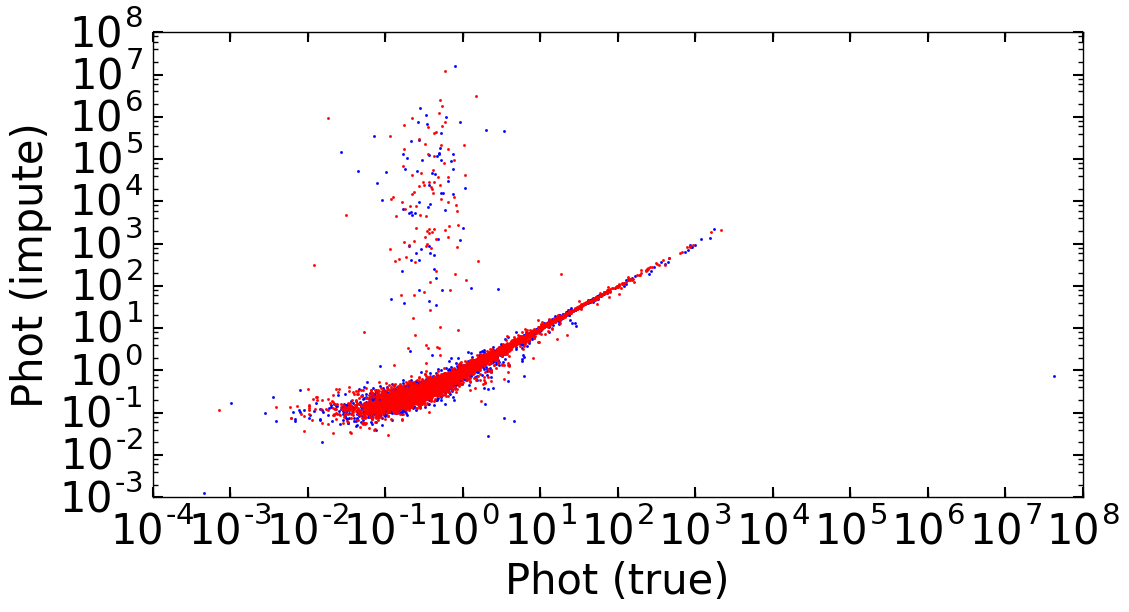

In [13]:
# plot photometric reconstruction
figure(figsize=(12,6))
loglog(phot_train_d[mask_train_d==False],p1[mask_train_d==False],'b.',markersize=3)
loglog(phot_test_d[mask_test_d==False],p2[mask_test_d==False],'r.',markersize=3)
xlabel('Phot (true)')
ylabel('Phot (impute)')

## Baseline

Adapting notation from Speagle et al. (2017), our baseline model is just:

\begin{equation}
P(\mathbf{h},\mathbf{f^h}|\mathbf{g}) \propto P(\mathbf{f^h}) P(\mathbf{h}|\mathbf{f^h}) P(\mathbf{g}|\mathbf{h}) = P(\mathbf{f^h})  \prod_{(\mathbf{h},\mathbf{g})} P(h|\mathbf{f^h}) P(g|h),
\end{equation}

with $\mathbf{h}$ our training galaxies, $\mathbf{g}$ our testing galaxies, and $\mathbf{f^h}$ the parameters of our population prior within the training set.

We can probe this distribution using a Gibbs sampler by alternating between sampling

\begin{equation}
P(\mathbf{f^h}|\mathbf{h},\mathbf{g})=P(\mathbf{f^h}|\mathbf{h}),
\end{equation}

which is simply Dirichlet distributed, and 

\begin{equation}
P(\mathbf{h}|\mathbf{f^h},\mathbf{g})= \prod_{(\mathbf{h},\mathbf{g})} P(h|\mathbf{f^h}) P(g|h),
\end{equation}

which is just the original likelihood modified by the new conditional population prior.

To state things a bit more plainly, our hierarchical model has two parts: a population component and an individual component. To sample from the joint hierarchical distribution, all we have to do is sample from each of the conditional distributions: the population assuming we know the individual components, and then the individual components assuming we know the population. We continue this interative sampling until the distribution converges, at which point we are sampling from the true stationary distribution.

Unlike the case in Leistedt et al. (2016), we actually are working with a large batch of "training data" with arbitrary labels. As a result, the distribution we want to sample from is directly in the training data space with no imposed structure (i.e. which training object $h$ a target object $g$ is associated with). Once we have solved for the joint distribution between $\mathbf{g}$ and $\mathbf{h}$, we can then paint on any distribution we like using the (joint) mappings from $\mathbf{h}$ to, say, $z$ (redshift) or $t$ (type), among others. 

Let's not get too far ahead of ourselves though. Let's first compute the FRANKEN-Z sparse likelihoods.

In [91]:
reload(fz)
frankenz=fz.FRANKENZ(N_members=25,n_neighbors=10) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,sqrt(v1),mask_train_d,p2,sqrt(v2),mask_test_d)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


This is one of the great thing about FRANKEN-Z's sparse representation of the likelihood: not only are we able to quickly iterate over the testing objects for computations, but because we are able to actually store all the likelihoods **ahead of time** (which is impossible for brute-force approaches at this scale), we can re-use them in our later calculations without spending time recomputing the same quantities.

There's also an additional bonus: because of the structure of our hierarchical model, we can automatically infer an individual object's PDF at any given iteration of our sampler using our pre-computed likelihoods and $\mathbf{f^h}$. This means we don't have to store any of those interim values (which is memory intensive), but instead can generate them on demand as needed!

Before we go on, let's quickly check whether our original distribution looks reasonable.

In [92]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 

Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


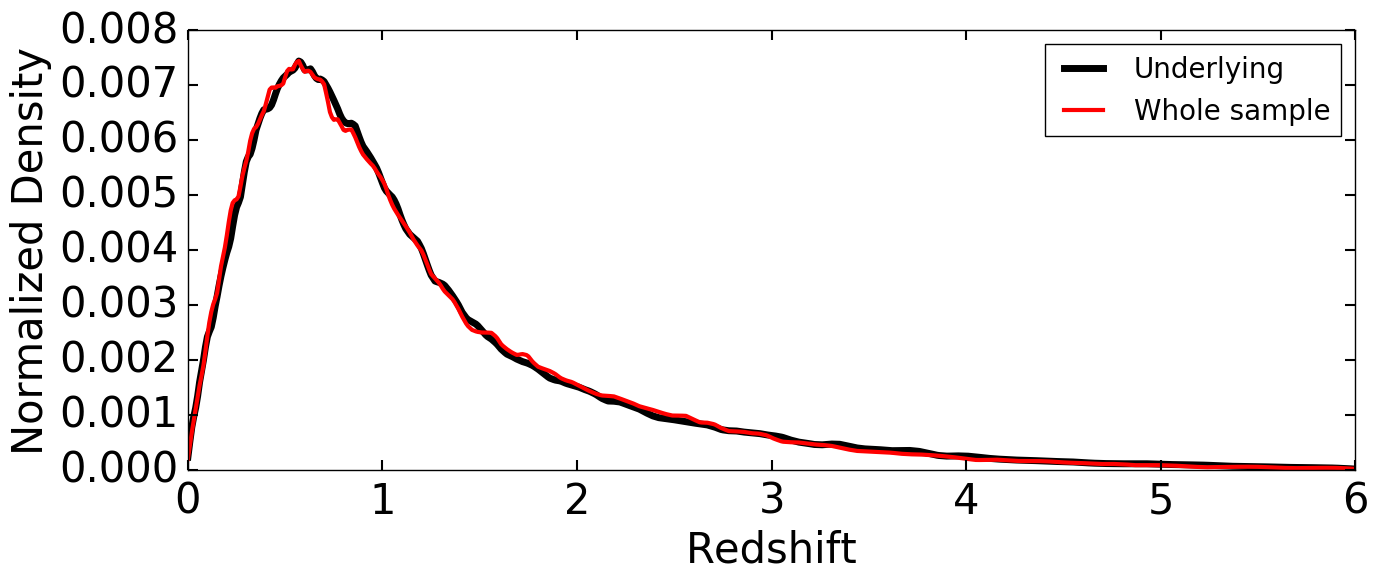

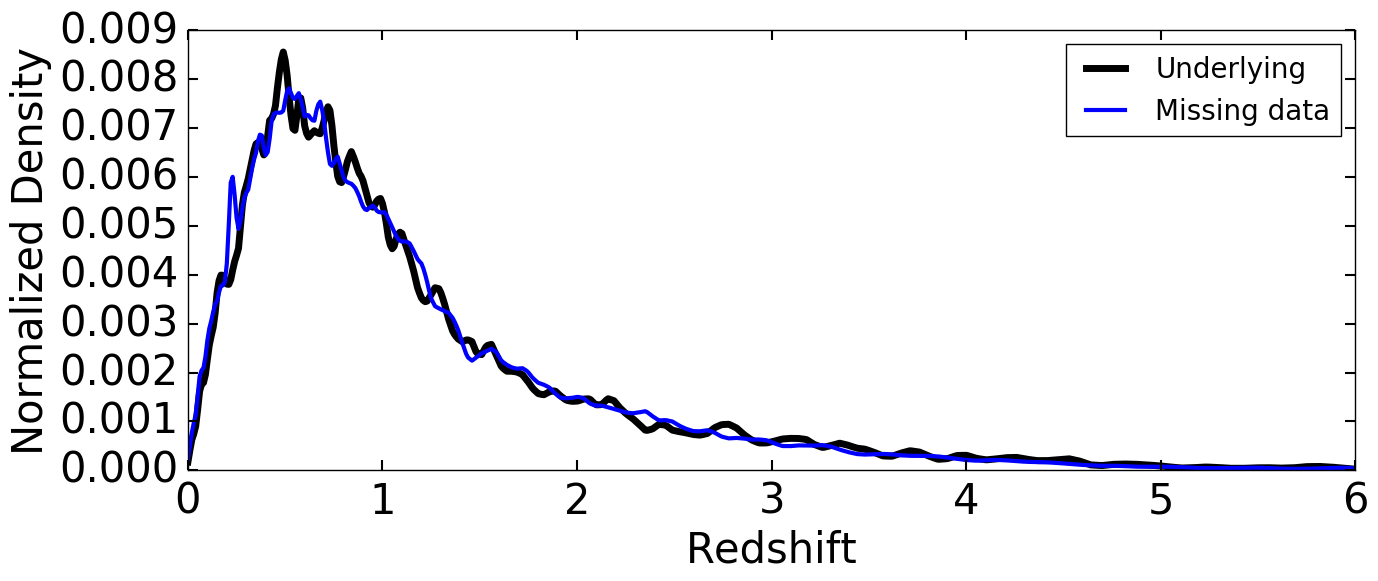

In [93]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='red',label='Whole sample')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,csel[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf_fz[csel[test_sel]],axis=0)/sum(csel[test_sel]),lw=3,color='blue',label='Missing data')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

That looks pretty good!

Now that we've computed our likelihoods, we need to set our population prior $P(\mathbf{f^h})$ and initialize our population parameter vector $\mathbf{f}^{\mathbf{h}}_0$.

In [94]:
p_fh=ones(Ntrain)/Ntrain # uniform prior
fh=zeros(Ntrain)
llmin=empty(Ntest) # min(log-likelihood)
model_like=copy(model_ll) # scaled likelihood

for i in xrange(Ntest):
    Nm=model_Nobj[i] # number of models
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm] # model indices and corresponding log-likelihoods
    llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-llmin[i])) # weights
    weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
    model_like[i][:Nm]=weights # assign scaled model likelihoods
    weights*=p_fh[midx] # multiply by global prior
    weights/=weights.sum() # normalize
    fh[midx]+=weights # stack

Now that everything's all set up, we generate a bunch of $\mathbf{f^h}$ samples.

In [95]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Ntest):
        Nm=model_Nobj[j] # number of models
        midx,like=model_obj[j][:Nm],model_like[j][:Nm] # model indices and corresponding log-likelihoods
        weights=like*fh_i[midx]*p_fh[midx] # (P(global)*P(conditional)*likelihood)
        weights/=weights.sum() # normalize
        fh_t[i+1][midx]+=weights

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

Let's first examine how this impacts an individual object's PDF.

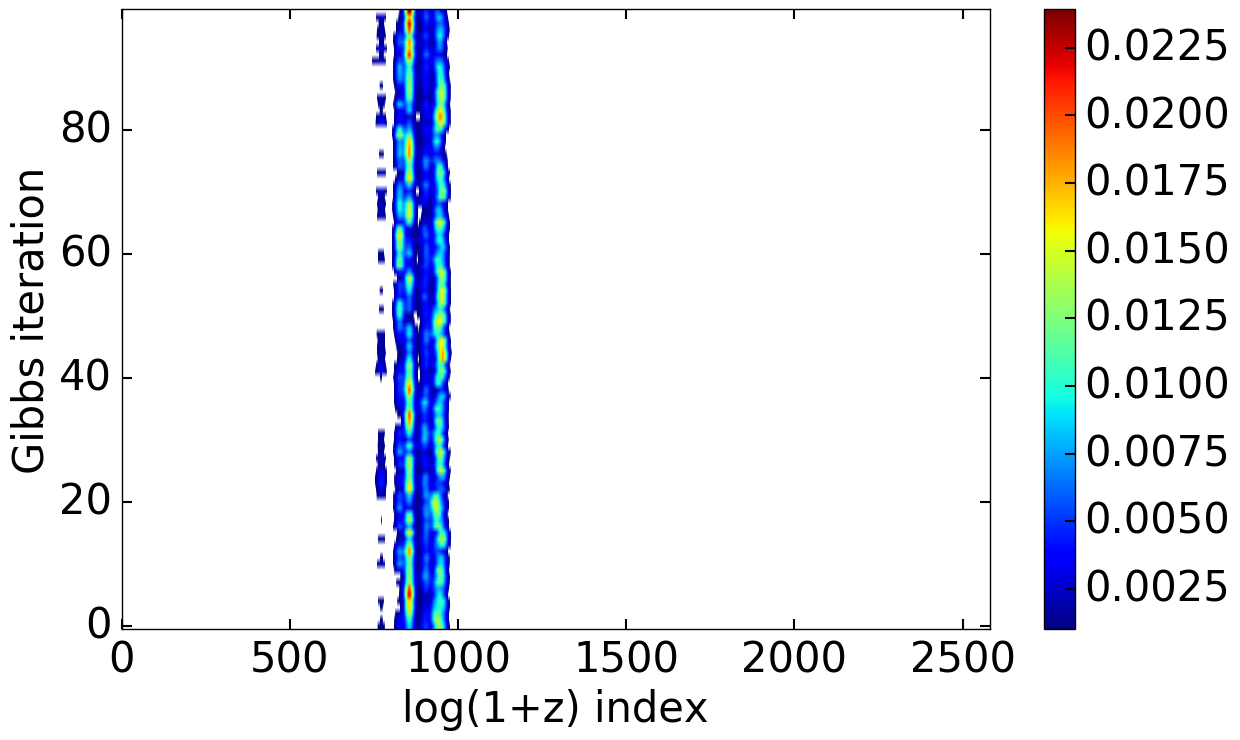

In [96]:
j=6 # object index
temp=array([fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,
                            lzidx_train_d[model_obj[j][:model_Nobj[j]]],lzeidx_train_d[model_obj[j][:model_Nobj[j]]],
                            model_like[j][:model_Nobj[j]]*fh_t[i][model_obj[j][:model_Nobj[j]]],
                            rdict.grid,rdict.delta,rdict.Ngrid) for i in xrange(N_samples)])
temp/=temp.sum(axis=1)[:,None]

figure(figsize=(14,8))
cmap=matplotlib.cm.jet
cmap.set_bad('white',1.)
imshow(ma.array(temp,mask=temp<1e-3),aspect='auto',cmap=cmap,origin='lower')
colorbar()
xlabel('log(1+z) index')
ylabel('Gibbs iteration')

As with standard Metropolis-Hastings Markov Chain Monte Carlo (MCMC) sampling, we first have to guarantee our sampler converges before we begin drawing values to derive a joint PDF. We *could* accomplish this using many sophisticated diagnostics, but because this is a simple test we just discard the first 20 values and call it a day. Mapping our new high-dimensional $\mathbf{f^h}$ samples to redshift space using KDE is then pretty straightforward.

**Important sidenote**: To properly condition a covariance/precision matrix, we need as many samples as "free parameters". This means we're limited by the resolution of our grid, and that saving on computation time using fewer samples will require downsampling our redshift, mass, etc. grid to coarser resolution using, e.g., binning.

In [97]:
N_burnin=20 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+' ')
    midx=choice(Ntrain,p=fh_t[i]/fh_t[i].sum(),size=Ntrain) # sample from f^h
    z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],ones(Ntrain),
                          rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
    z_pdf/=z_pdf.sum()
    z_pdf_draws[i-N_burnin]=z_pdf
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()

20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

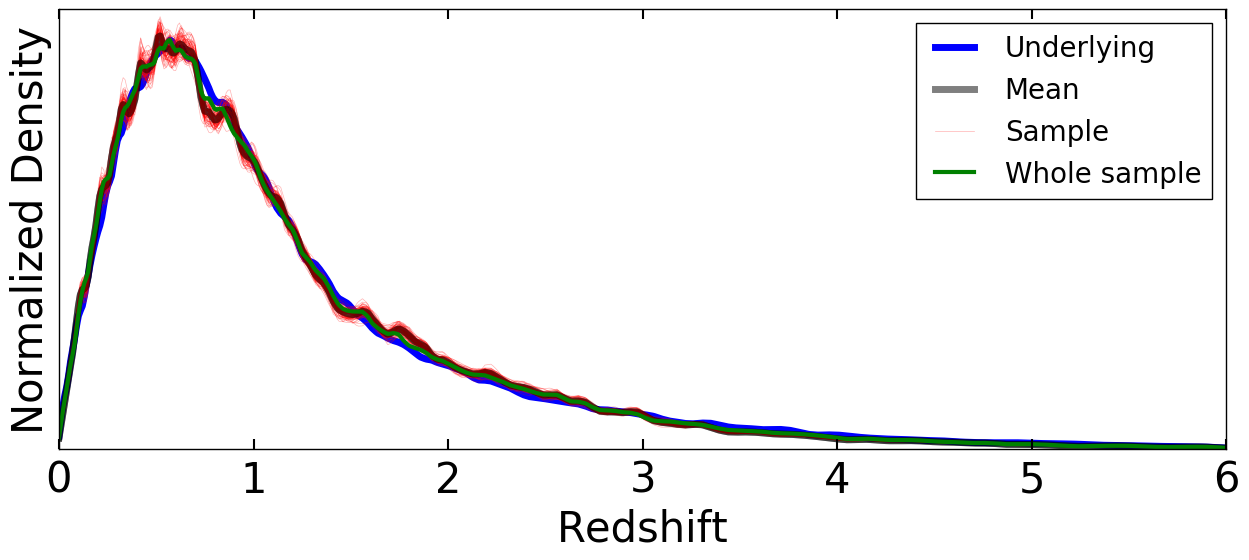

In [98]:
figure(figsize=(14,6))

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='blue',label='Underlying')

plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5,label='Mean')
plot(rdict.zgrid_out,z_pdf_draws[0],lw=0.5,color='red',alpha=0.3,label='Sample')
[plot(rdict.zgrid_out,z_pdf_draws[i+1],lw=0.5,color='red',alpha=0.3) for i in xrange(N_samples-N_burnin-1)]
plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5)
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='green',label='Whole sample')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
tight_layout()
legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('Normalized Density')

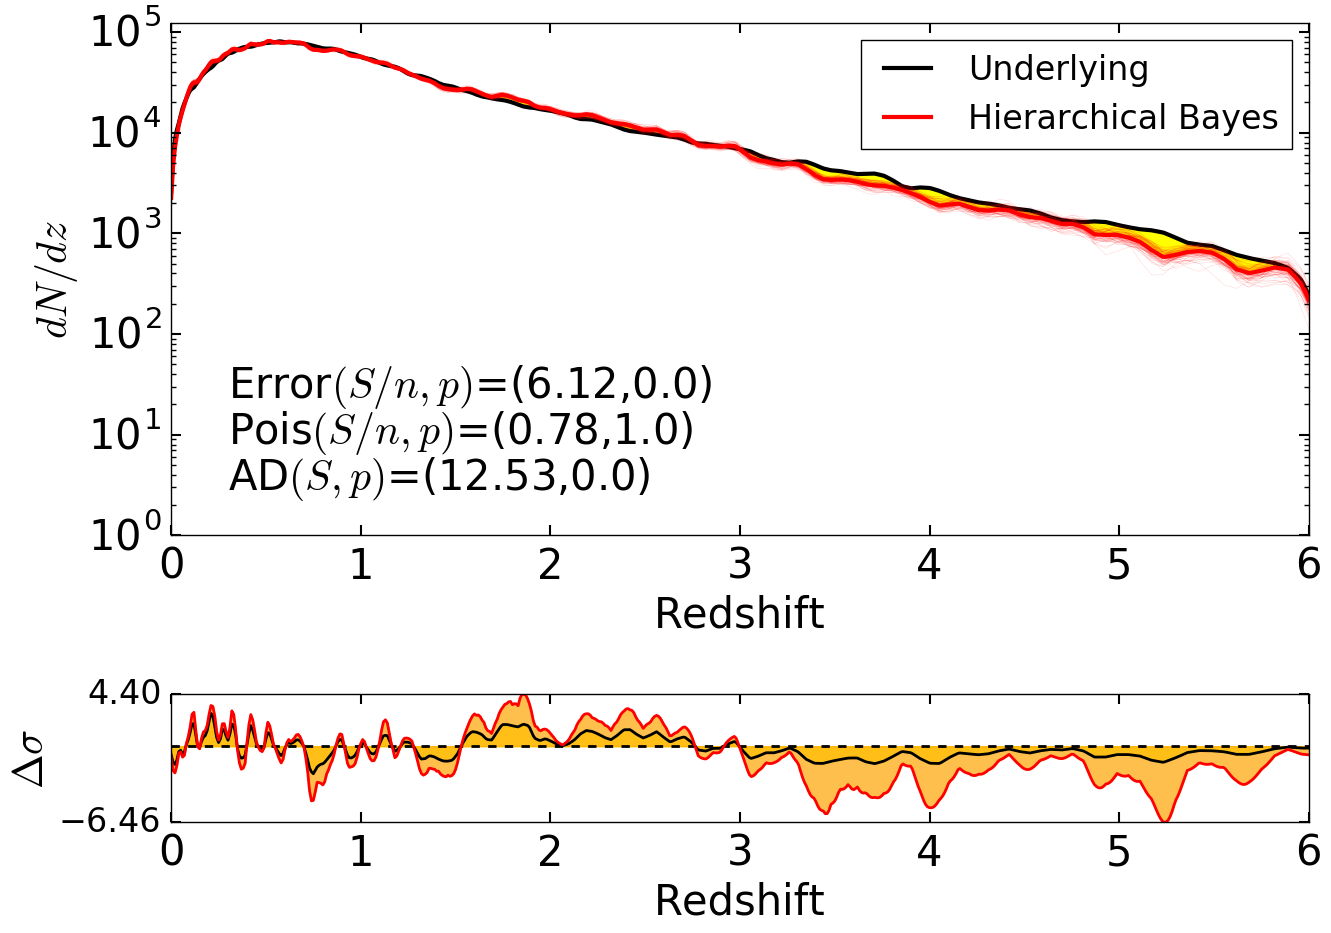

In [99]:
figure(figsize=(14,10))
Q_pois,Q_ad,Q_err=fz.plot_nz(z_pdf*Ntest,z_pdf_draws_mean*Ntest,rdict.zgrid_out,rdict.dz_out,out_nz_draws=z_pdf_draws*Ntest,
                             sample_names=['Underlying','Hierarchical Bayes'],colors=['black','red'])

In this case, we see that we get broadly similar error behavior between the naive hierarchical modeling errors computed from the samples (ignoring covariances among redshift bins) at $z<3$, especially when the number density is high. However, at lower number densities, we see that our hierarhical modeling errors systematically underestimate the true amount of possible variation. These will be addressed in the next section.

## Incorporating selection effects

We now want to add a little bit of complexity to our model by incorporating in the impact of **selection effects** on the **testing** sample $\mathbf{g}$ using a new selection flag $\boldsymbol{\gamma}$.

Conditioning on $\boldsymbol{\gamma}$, our modified model now reads:

\begin{equation}
P(\mathbf{h},\mathbf{f^h}|\mathbf{g},\boldsymbol{\gamma}) \propto P(\mathbf{f^h}|\boldsymbol{\gamma}) P(\mathbf{h}|\mathbf{f^h},\boldsymbol{\gamma}) P(\mathbf{g}|\mathbf{h},\boldsymbol{\gamma}) = P(\mathbf{f^h})  \prod_{(\mathbf{h},\mathbf{g})} P(h|\mathbf{f^h}) P(g|h,\gamma).
\end{equation}

The only change relative to our original model is the term $P(g|h,\gamma)$, which can be written as:

\begin{equation}
P(g|h,\gamma)=\frac{P(g|h)P(\gamma|g)}{P(\gamma|h)}=\frac{P(g|h)P(\gamma|g)}{\int P(g|h)P(\gamma|g) dg},
\end{equation}

where the integral in the denominator is taken over all possible flux realizations of $g$.

We first want to outline an explicit example of how this works for a simple selection function: a multi-dimensional flux cut along some flux vector $\mathbf{F}_{cut}$ (like we have done with the $i$-band). In the scale-dependent likelihood case where the flux density for object $i$ with mean $\mathbf{\hat{F}}_i$ and covariance $\mathbf{\hat{C}}_i$ is normally distributed with PDF $\mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_i,\mathbf{\hat{C}}_i)$, then 

\begin{equation}
P(g|h) = \frac{1}{C} \int \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)\mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_h,\mathbf{\hat{C}}_h) d\mathbf{F} = \frac{S_{hg}}{\sum_h S_{hg}},
\end{equation}
\begin{equation}
S_{hg} = \mathcal{N}(\mathbf{\hat{F}}_h|\mathbf{\hat{F}}_{g},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g}).
\end{equation}

Our selection function can be written as:

\begin{equation}
P(\gamma|g)=\prod_i H(\hat{F}_{g,i}-(F_{cut})_i)=H(\mathbf{\hat{F}}_g-\mathbf{F}_{cut}),
\end{equation}

where $H$ is the Heavyside function, which evaluates to 1 for all $\mathbf{\hat{F}}_g>\mathbf{F}_{cut}$ elementwise and 0 otherwise.

The denominator is now the convolution of our original likelihood with the selection function, which gives:

\begin{equation}
P(\gamma|h) = \int P(g|h)P(\gamma|g) dg = \frac{1}{C} \int \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{\hat{F}}_{h},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g}) H(\mathbf{\hat{F}}_g-\mathbf{F}_{cut}) d\mathbf{\hat{F}}_g = \frac{S^\prime_{hg}(\mathbf{F}_{cut})}{\sum_h S^\prime_{hg}(\mathbf{F}_{cut})},
\end{equation}
\begin{equation}
S^\prime_{hg}(\mathbf{F}_{cut}) \equiv \int_{\mathbf{F}_{cut}}^{+\infty} \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{\hat{F}}_{h},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g}) d\mathbf{\hat{F}}_g.
\end{equation} 

This gives:

\begin{equation}
P(g|h,\gamma)=\frac{P(g|h)P(\gamma|g)}{P(\gamma|h)} = \frac{\sum_h S^\prime_{hg}(\mathbf{F}_{cut})}{\sum_h S_{hg}} \frac{S_{hg}}{S^\prime_{hg}(\mathbf{F}_{cut})},
\end{equation}

since by definition $H(\mathbf{\hat{F}}_g-\mathbf{F}_{cut})=1$ for all all objects included in the sample. This leads us to **boost** the relative contribution from objects by an amount inversely proportional to the **fraction of the original likelihood contained within the selection boundary**, which ranges from $1 \leq 1/S^\prime_{hg}(\mathbf{F}_{cut}) \leq 2^d$ where $d$ is the number of filters.

In other words, the likelihood we use when fitting an object can be viewed (via symmetry) as the probability that the $\mathbf{\hat{F}}_g$ is a certain value given $\mathbf{\hat{F}}_h$. However, the selection function effectively truncates this likelihood at $\mathbf{F}_{cut}$ across our sample. We need to correct for this effect, which requires dividing the original result by the expected truncation, giving us a factor of ${S_{hg}}/{S^\prime_{hg}(\mathbf{F}_{cut})}$.

In [ ]:
t1,t2=phot_train_d[1][2],sqrt(var_train_d[1][2])
samples=normal(t1,t2,size=(10000))
qx=fz.gaussian(t1,t2**2,samples)
fx=fz.gaussian(t1,(t2*0.7)**2,samples)
sum(fx/qx)/len(samples)

In [ ]:
plot(samples,qx,'.')
plot(samples,fx,'.')

In [ ]:
fcut=phot_train_d[2]
fmu=phot_train_d[2]
fstd=sqrt(var_train_d[2])
t2=(fcut-fmu)/(sqrt(2)*fstd)
print t2
print 1./prod(1-0.5*erfc(-t2)),2**5 # Diag-Cov Multivariate Gaussian Integration

STUFF about selection flux marginalization machine learning. We know what the MVG is for P(g|h) w/ associated normalization from the likelihoods and such, so that's easy. The second term might have some complicated form, necessitating numerical integration. If we Monte Carlo some fluxes, we should be able to evaluate it. Let's try the simple selection first and then scale up to something harder w/ ML.

To state things a bit more plainly, STUFF.